In [2]:
from google.colab import drive
drive.mount ('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer
from scipy.stats import ttest_rel
from pandas import read_csv
import pickle
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

#display max columns
pd.set_option('display.max_columns', 100)
#pd.set_option('display.max_rows', 200)

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [3]:
# !pip install -U scikit-learn
!pip show scikit-learn

Name: scikit-learn
Version: 1.2.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: bigframes, fastai, imbalanced-learn, librosa, mlxtend, qudida, sklearn-pandas, yellowbrick


About Dataset

**Context**
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. **In particular, all patients here are females at least 21 years old of Pima Indian heritage.**

**Content**
The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

Acknowledgements
Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.

In [4]:
path = '/content/drive/MyDrive/Colab Notebooks/Data/'

In [5]:
df = pd.read_csv(path+'diabetes.csv')
print(df.shape)
df.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## Columns

### Independent Variables

1.   Pregnancies

1.   Glucose (Plasma Glucose Conc 2hrs post OGTT)

1.   BloodPressure (Diastolic)
2.   SkinThickness

5.   Insulin (2 hour serum insulin(mu U/ml))
6.   BMI
7.   DiabetesPedigreeFunction (calculates diabetes likelihood depending on the subject's age and his/her diabetic family history.)
8.   Age

### Dependent/Target Variable    
 9   Outcome

In [7]:
#make column names lower case
df = df.rename(columns=lambda x: x.lower())

In [8]:
#There are no null values in the dataset looking at the df.info()
#check for duplicates

df.duplicated().any()

False

In [9]:
#there are no duplicates
df.describe()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


While there are no non-null values or duplicates in the dataset, there are however zero values which are not meant to be looking at the minimum values in the descriptive statistics for the numerical columns (all columns here are numerical)


It can be possible a woman has no pregnancies hence the minium can be zero, but it is not possible to have zero values for glucose, bloodpressure, skin thickness, insulin and bmi.

We will deal with this by first mapping all the zero values in these columns to nan and then perform KNN imputation to fill the missing values.

In [10]:
df[['glucose','bloodpressure','skinthickness','insulin','bmi']] = df[
    ['glucose','bloodpressure','skinthickness','insulin','bmi']].replace(0,np.NaN)

In [11]:
#Now, let us look at the df.info again

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pregnancies               768 non-null    int64  
 1   glucose                   763 non-null    float64
 2   bloodpressure             733 non-null    float64
 3   skinthickness             541 non-null    float64
 4   insulin                   394 non-null    float64
 5   bmi                       757 non-null    float64
 6   diabetespedigreefunction  768 non-null    float64
 7   age                       768 non-null    int64  
 8   outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


In [12]:
df.count()

pregnancies                 768
glucose                     763
bloodpressure               733
skinthickness               541
insulin                     394
bmi                         757
diabetespedigreefunction    768
age                         768
outcome                     768
dtype: int64

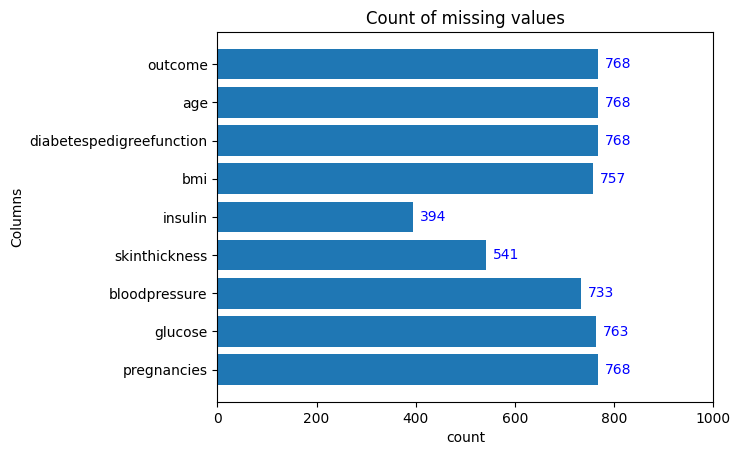

In [13]:
#We can see there are null values in the dataset which can be visually appreciated

fig, ax = plt.subplots()

bar = plt.barh(df.columns,df.count())

plt.bar_label(bar, padding=5, color='b')
ax.set_xlim(right=1000)
plt.title("Count of missing values")
plt.ylabel("Columns")
plt.xlabel("count");

## **EDA**

Univariate analysis

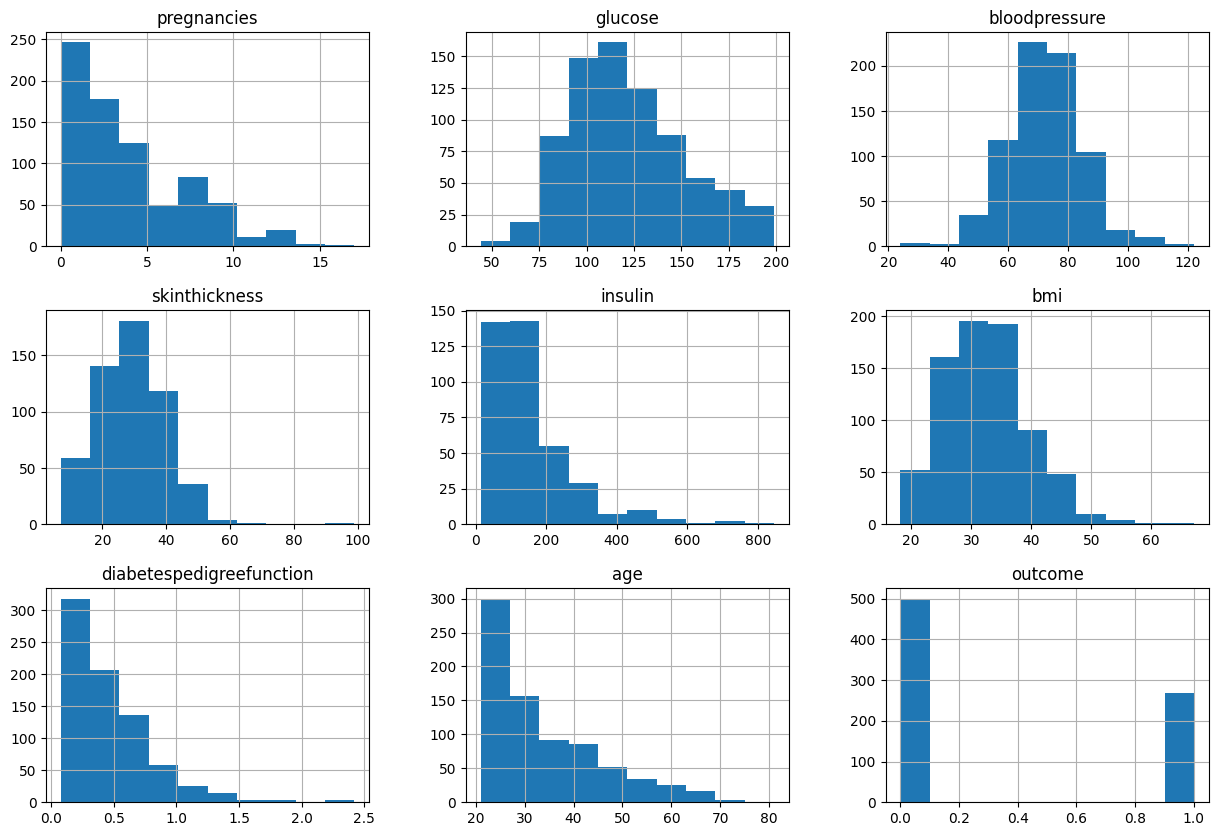

In [15]:
df.hist(bins=10, figsize=(15,10));

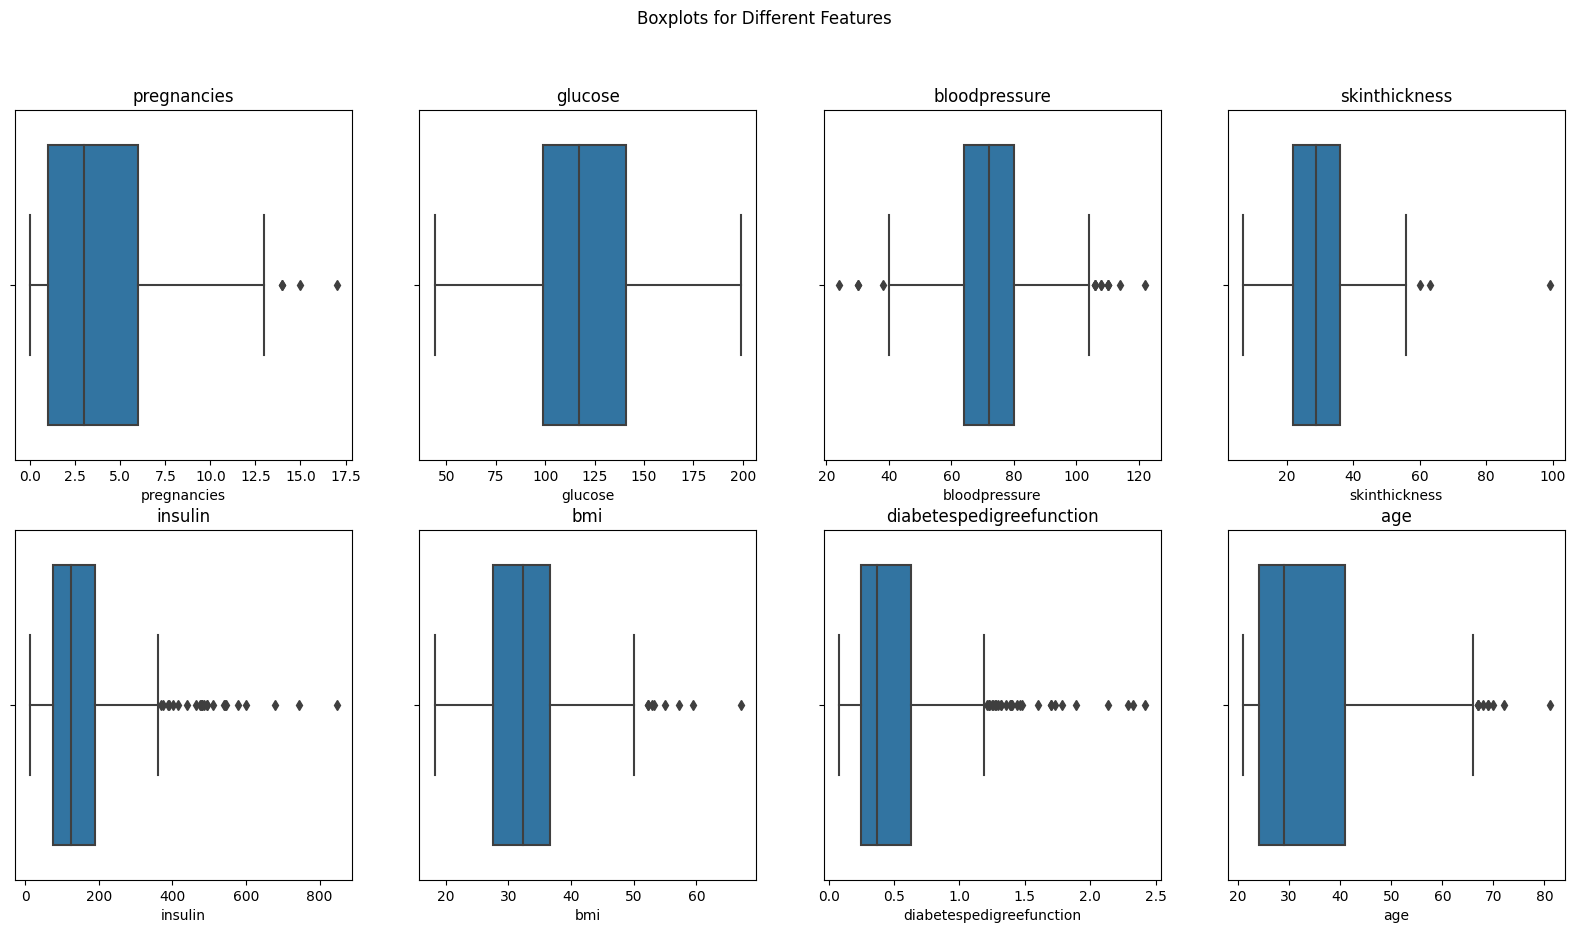

In [28]:
features = ['pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin', 'bmi', 'diabetespedigreefunction', 'age']

# Create a subplot grid
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle("Boxplots for Different Features")

# Loop through the features and create boxplots on different subplots
for i, feature in enumerate(features):
    row, col = divmod(i, 4)  # Determine the row and column for each subplot
    sns.boxplot(data=df, x=feature, ax=axes[row, col])
    axes[row, col].set_title(feature)

plt.show()

MODEL BUILDING

In [16]:
# load the dataset
def load_dataset(filename, k_neighbors=5):
    data = read_csv(filename)
    X = data.values[:, :-1]  # Features
    y = data.values[:, -1]   # Target variable

    # Initialize the KNN imputer
    imputer = KNNImputer(n_neighbors=k_neighbors)

    # Impute missing values
    X_imputed = imputer.fit_transform(X)

    return X_imputed, y

# feature selection
def select_features(X_train, y_train, X_test, k):
    fs = SelectKBest(score_func=f_classif, k=k)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs


# load the dataset
X, y = load_dataset(path+'diabetes.csv', k_neighbors=5)
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# Define the models
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=1),
    'SVM': SVC(random_state=1),
    'Random Forest': RandomForestClassifier(random_state=1)
}

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['k'] + list(models.keys()))

# Iterate over different numbers of features (k) and different models
for k in range(1, 9):
    row = {'k': k}
    for model_name, model in models.items():
        # Feature selection
        X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, k)

        # Fit the model
        model.fit(X_train_fs, y_train)

        # Make predictions
        yhat = model.predict(X_test_fs)

        # Evaluate predictions
        accuracy = accuracy_score(y_test, yhat)

        # Store accuracy in the DataFrame
        row[model_name] = accuracy

    # Append the row to the results DataFrame
    results_df = results_df.append(row, ignore_index=True)


In [17]:
# Print the results in tabular form
results_df

,k,Logistic Regression,SVM,Random Forest
0,1.0,0.755906,0.759843,0.728346
1,2.0,0.759843,0.763780,0.759843
2,3.0,0.775591,0.783465,0.779528
3,4.0,0.787402,0.775591,0.775591
4,5.0,0.779528,0.775591,0.783465
5,6.0,0.779528,0.763780,0.783465
6,7.0,0.783465,0.763780,0.779528
7,8.0,0.775591,0.767717,0.783465


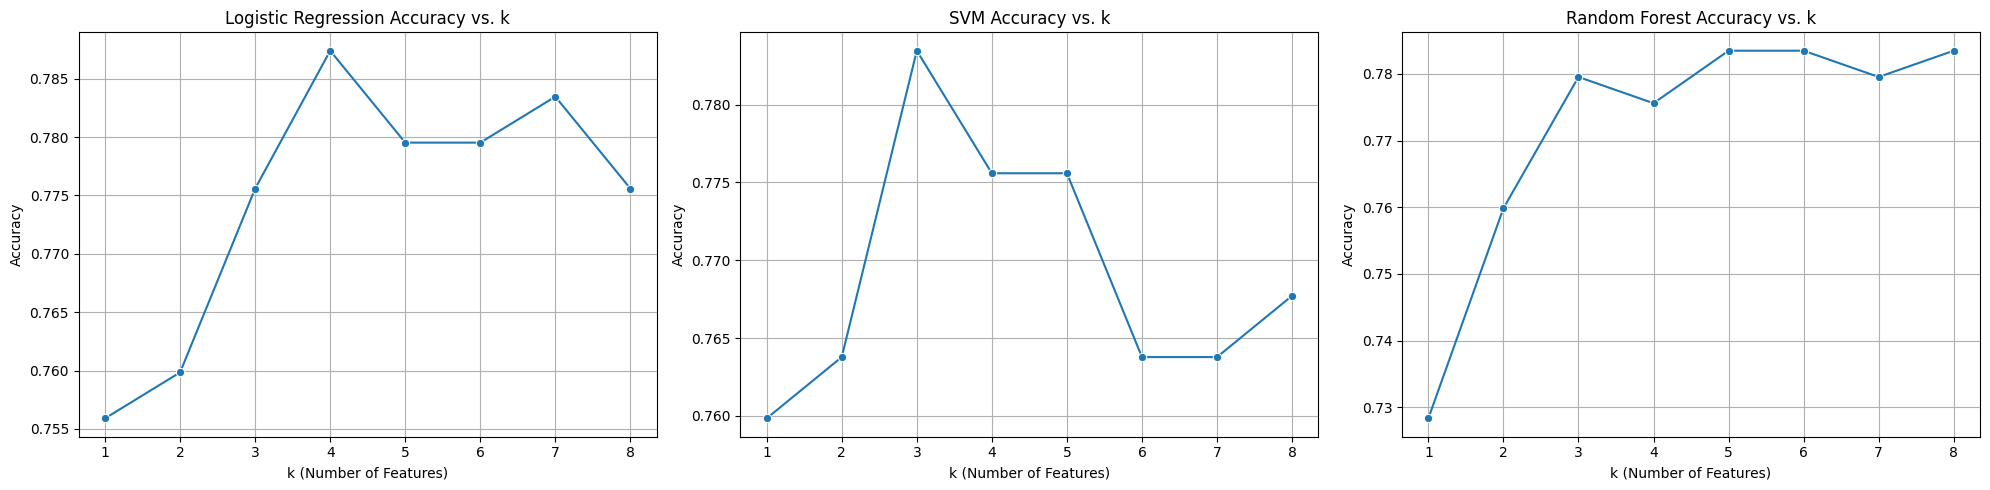

In [18]:
# Define a function to create subplots for each model
def create_model_accuracy_subplots(data):
    model_names = list(models.keys())
    num_models = len(model_names)

    fig, axs = plt.subplots(1, num_models, figsize=(20, 5))

    for i, model_name in enumerate(model_names):
        sns.lineplot(x='k', y=model_name, data=data, marker='o', ax=axs[i])
        axs[i].set_title(f'{model_name} Accuracy vs. k')
        axs[i].set_xlabel('k (Number of Features)')
        axs[i].set_ylabel('Accuracy')
        axs[i].grid(True)

    plt.tight_layout()

# Create subplots for each model
create_model_accuracy_subplots(results_df)
plt.show()


In [19]:
# Find the best model for each 'k'
best_model_for_k = results_df.set_index('k').idxmax(axis=1).reset_index()
best_model_for_k.columns = ['k', 'Best_Model']

# Find the 'k' that gives the best accuracy for each model
best_k_for_model = results_df.melt(id_vars=['k'], var_name='Model', value_name='Accuracy')
best_k_for_model = best_k_for_model.sort_values(by='Accuracy', ascending=False).groupby('Model').head(1)

In [20]:
# Display the best model for each 'k'
print("Best Model for Each 'k':")
best_model_for_k

Best Model for Each 'k':


,k,Best_Model
0,1.0,SVM
1,2.0,SVM
2,3.0,SVM
3,4.0,Logistic Regression
4,5.0,Random Forest
5,6.0,Random Forest
6,7.0,Logistic Regression
7,8.0,Random Forest


In [21]:
# Display the 'k' that gives the best accuracy for each model
print("\nBest 'k' for Each Model:")
best_k_for_model


Best 'k' for Each Model:


,k,Model,Accuracy
3,4.0,Logistic Regression,0.787402
23,8.0,Random Forest,0.783465
10,3.0,SVM,0.783465


In [22]:
# Find the overall best model and 'k' based on accuracy
overall_best = results_df.melt(id_vars=['k'], var_name='Model', value_name='Accuracy')
overall_best = overall_best.sort_values(by='Accuracy', ascending=False).iloc[0]

# Display the overall best model and 'k'
print("Overall Best Model and 'k' Based on Accuracy:")
print(overall_best)

Overall Best Model and 'k' Based on Accuracy:
k                           4.0
Model       Logistic Regression
Accuracy               0.787402
Name: 3, dtype: object


In [23]:
# Select the accuracy values for Logistic Regression and Random Forest
accuracy_lr = results_df['Logistic Regression']
accuracy_rf = results_df['Random Forest']

# Perform a paired t-test
t_stat, p_value = ttest_rel(accuracy_lr, accuracy_rf)

# Define the significance level (alpha)
alpha = 0.05

# Check if the p-value is less than alpha (0.05)
if p_value < alpha:
    print(f"The difference in performance is statistically significant (p-value = {p_value:.4f}).")
    if t_stat > 0:
        print("Logistic Regression performs significantly better.")
    else:
        print("Random Forest performs significantly better.")
else:
    print(f"The difference in performance is not statistically significant (p-value = {p_value:.4f}).")

The difference in performance is not statistically significant (p-value = 0.4974).


In [24]:
# Define the metrics you want to evaluate
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1_score': make_scorer(f1_score, average='weighted')
}

# Define the models
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear'),
    'Random Forest': RandomForestClassifier()
}

# Create an empty DataFrame to store the results
results = pd.DataFrame(index=scoring.keys())

# Iterate over the models
for model_name, model in models.items():
    model_scores = {}  # Store scores for each metric
    # Perform cross-validation for each metric
    for metric_name, metric in scoring.items():
        scores = cross_val_score(model, X, y, cv=5, scoring=metric)
        mean_score = scores.mean()
        model_scores[metric_name] = mean_score
    # Add the model's scores as a column in the DataFrame
    results[model_name] = pd.Series(model_scores)


In [25]:
# Print the DataFrame
results

,Logistic Regression,Random Forest
accuracy,0.768271,0.768296
precision,0.764957,0.765679
recall,0.768271,0.765733
f1_score,0.758153,0.750388


In [26]:
# evaluation of a model using 4 features chosen with anova f-test


# load the dataset

def load_dataset(filename, k_neighbors=5):
    data = read_csv(filename)
    X = data.values[:, :-1]  # Features
    y = data.values[:, -1]   # Target variable

    # Initialize the KNN imputer
    imputer = KNNImputer(n_neighbors=k_neighbors)

    # Impute missing values
    X_imputed = imputer.fit_transform(X)

    return X_imputed, y


# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_classif, k=4)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# load the dataset
X, y = load_dataset(path+'diabetes.csv')
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# fit the model
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train_fs, y_train)
# evaluate the model
yhat = model.predict(X_test_fs)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 78.74


In [27]:
# Get a boolean mask of selected features
selected_features_mask = fs.get_support()

# Get the indices of the selected features
selected_feature_indices = [i for i, selected in enumerate(selected_features_mask) if selected]

# Print the indices of selected features
print("Selected feature indices:", selected_feature_indices)

Selected feature indices: [0, 1, 5, 7]


In [28]:
selected_features_mask

array([ True,  True, False, False, False,  True, False,  True])

In [29]:
feature_names = df.columns

# Get a boolean mask of selected features
selected_features_mask = fs.get_support()

# Get the names of the selected features
selected_feature_names = [feature_names[i] for i, selected in enumerate(selected_features_mask) if selected]

# Print the names of selected features
print("Selected feature names:", selected_feature_names)


Selected feature names: ['pregnancies', 'glucose', 'bmi', 'age']


In [29]:
input_data = (6,160,28.8,51)

# changing the input_data to numpy array
input_data_as_numpy_array = np.asarray(input_data)

# reshape the array as we are predicting for one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

prediction = model.predict(input_data_reshaped)
print(prediction)

if (prediction[0] == 0):
  print('The person is not diabetic')
else:
  print('The person is diabetic')

NameError: ignored

Saving the trained model

In [31]:
# Save the model to a file
with open('model_diabetesprediction.pkl', 'wb') as file:
    pickle.dump(model, file)

In [32]:
with open('model_diabetesprediction.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [33]:
input_data = (6,70,28.8,51)

# changing the input_data to numpy array
input_data_as_numpy_array = np.asarray(input_data)

# reshape the array as we are predicting for one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

prediction = loaded_model.predict(input_data_reshaped)
print(prediction)

if (prediction[0] == 0):
  print('The person is not diabetic')
else:
  print('The person is diabetic')

[0.]
The person is not diabetic


In [34]:
final = pd.DataFrame(X_test_fs,yhat, columns=selected_feature_names)
final

,pregnancies,glucose,bmi,age
0.0,7.0,136.0,26.0,51.0
0.0,1.0,151.0,26.1,22.0
0.0,6.0,109.0,25.0,27.0
0.0,3.0,61.0,34.4,46.0
0.0,1.0,116.0,36.1,25.0
...,...,...,...,...
0.0,2.0,89.0,33.5,42.0
0.0,7.0,105.0,0.0,24.0
1.0,3.0,158.0,31.6,28.0
0.0,6.0,96.0,23.7,28.0
